In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

This code calculates the estimates and worst case scenarios for my simulation of uncertainty around insulin therapy. Insulin absorption is modeled with the scalable exponential curves developed by Dr. Dragan Maksimovik for the [Loopkit artificial pancreas project](https://github.com/LoopKit/Loop/issues/388). I found this [repo](https://github.com/ps2/LoopIOB) very useful to get started.

In [6]:
# parameters

cir = 10.0              # carbs to insulin ratio
isf = 40.0              # insulin sensitivity factor
td = 360.0              # duration
tp = 75.0               # time to activity peak
starting_bg = 85.0      # at 8am
target = 90.0           # to be mantained throughout the day


In [7]:
def carbs_effect(day, carbs, start, delta):
    
    duration = int(np.ceil(carbs/(0.5*delta)))
    
    end = start + duration
    
    lst = [0]*start + [(carbs/duration)/cir*isf]*duration + [0]*(day-end)
    
    return lst


def dose(current_bg, carbs):
    
    return np.floor((current_bg + (carbs/ cir * isf) - target)/isf)


def dose_snack(carbs):
    
    # no reading for snacks
    
    return np.floor(carbs/cir)


def scalable_exp_iob(t, tp, td, start):
    
    # models insulin absorption
    
    t_rescaled = t-start
    
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*tau/td
    S = 1/(1-a+(1+a)*np.exp(-td/tau))  
    
    return 1-S*(1-a)*((pow(t_rescaled,2)/(tau*td*(1-a)) - t_rescaled/tau - 1)*np.exp(-t_rescaled/tau)+1)


def insulin_effect(day, tp, td, start, bg, carbs, delta_dose, delta_isf, snack_flag):
    
    end = start + int(td)
    
    current_bg = bg[start]
    
    if snack_flag==0:
        
        conv_dose = dose(current_bg, carbs)*delta_dose*isf*delta_isf
        
    else:
        
        conv_dose = dose_snack(carbs)*delta_dose*isf*delta_isf
    
    iob = [round(-(1-scalable_exp_iob(t, tp, td, start))*conv_dose, 4) for t in range(start,day)]
    
    if end<day:
        
        idx_f = iob.index(-round(conv_dose,4))
        iob = iob[:idx_f+1]
    
    bolus = [0]*start + iob + [0]*abs(day-start-len(iob))
            
    return bolus[:day]

In [126]:
# 18h monitoring: from 8am till 2am next day

# breakfast: 8am; lunch: 2pm; snack: 6pm; dinner: 8pm.

# Mayo diet:

#breakfast1 = 50
#lunch1 = 44
#snack1 = 13
#dinner1 = 32

# LCHF:

#breakfast1 = 3
#lunch1 = 3
#snack1 = 6
#dinner1 = 11

# USDA:

breakfast1 = 76
lunch1 = 26
snack1 = 40
dinner1 = 59


day = 1082 # monitoring period in minutes (t_dinner-10+432)

t_breakfast = 10          # 8:10am 
t_lunch = (14-8)*60       # 2pm
t_snack = (18-8)*60       # 6pm
t_dinner = (20-8)*60      # 8pm

### Insulin absorption & action + total carb bioavailability + meal absorption rate (GI)

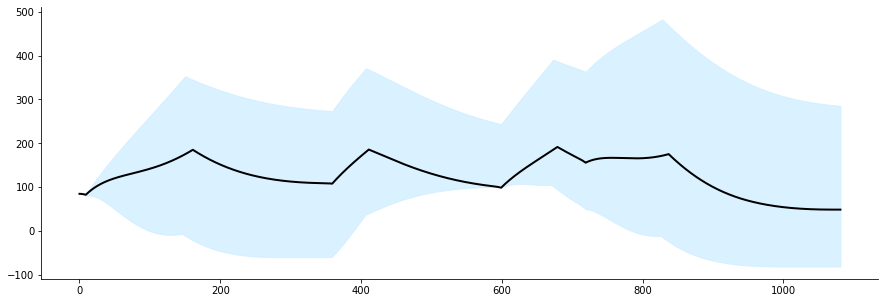

In [127]:
# starting blood sugars:

y0 = [starting_bg] + [0]*(day-1)



# ESTIMATED CURVE:

tp = 75
td = 360

# breakfast

breakfast = carbs_effect(day, breakfast1, t_breakfast, 1)
bolus1 = insulin_effect(day, tp, td, t_breakfast-10, y0, breakfast1, 1, 1, 0)

y = [sum(x) for x in zip(y0, breakfast)]
bg_est = [sum(x) for x in zip(np.cumsum(y), bolus1)]

idx = int(t_breakfast-10+td)
end_ia = bg_est[idx-1]
bg_est = bg_est[:idx] + [end_ia]*(day-idx)

# lunch

lunch = carbs_effect(day, lunch1, t_lunch, 1)
bolus2 = insulin_effect(day, tp, td, t_lunch-10, bg_est, lunch1, 1, 1, 0)

y = [sum(x) for x in zip(bg_est, np.cumsum(lunch))]
bg_est = [sum(x) for x in zip(y, bolus2)] # update bg_est

idx = int(t_lunch-10+td)
end_ia = bg_est[idx-1]
bg_est = bg_est[:idx] + [end_ia]*(day-idx)

# snack

snack = carbs_effect(day, snack1, t_snack, 1)
bolus3 = insulin_effect(day, tp, td, t_snack-10, bg_est, snack1, 1, 1, 1)

y = [sum(x) for x in zip(bg_est, np.cumsum(snack))]
bg_est = [sum(x) for x in zip(y, bolus3)] # update bg_est

idx = int(t_snack-10+td)
end_ia = bg_est[idx-1]
bg_est = bg_est[:idx] + [end_ia]*(day-idx)

# dinner

dinner = carbs_effect(day, dinner1, t_dinner, 1)
bolus4 = insulin_effect(day, tp, td, t_dinner-10, bg_est, dinner1, 1, 1, 0)

y = [sum(x) for x in zip(bg_est, np.cumsum(dinner))]
bg_est = [sum(x) for x in zip(y, bolus4)] # update bg_est

if t_dinner-10+td < day:
    
    idx = int(t_dinner-10+td)
    end_ia = bg_est[idx-1]
    bg_est = bg_est[:idx] + [end_ia]*(day-idx)
    


# HYPO LIMIT:

# patient overestimates carbs and carb absorption time and underestimates insulin absorption and action.

tp = 52.5
td = 288

# breakfast

breakfast = carbs_effect(day, breakfast1*0.7*0.9, t_breakfast, 0.7)
bolus1 = insulin_effect(day, tp, td, t_breakfast-10, y0, breakfast1, 1, 1.2, 0)

y = [sum(x) for x in zip(y0, breakfast)]
bg_upper = [sum(x) for x in zip(np.cumsum(y), bolus1)]

idx = int(t_breakfast-10+td)
end_ia = bg_upper[idx-1]
bg_upper = bg_upper[:idx] + [end_ia]*(day-idx)

# lunch

lunch = carbs_effect(day, lunch1*0.7*0.9, t_lunch, 0.7)
bolus2 = insulin_effect(day, tp, td, t_lunch-10, bg_upper, lunch1, 1, 1.2, 0)

y = [sum(x) for x in zip(bg_upper, np.cumsum(lunch))]
bg_upper = [sum(x) for x in zip(y, bolus2)] # update bg_upper

idx = int(t_lunch-10+td)
end_ia = bg_upper[idx-1]
bg_upper = bg_upper[:idx] + [end_ia]*(day-idx)

# snack

snack = carbs_effect(day, snack1*0.7*0.9, t_snack, 0.7)
bolus3 = insulin_effect(day, tp, td, t_snack-10, bg_upper, snack1, 1, 1.2, 1)

y = [sum(x) for x in zip(bg_upper, np.cumsum(snack))]
bg_upper = [sum(x) for x in zip(y, bolus3)] # update bg_upper

idx = int(t_snack-10+td)
end_ia = bg_upper[idx-1]
bg_upper = bg_upper[:idx] + [end_ia]*(day-idx)


# dinner

dinner = carbs_effect(day, dinner1*0.7*0.9, t_dinner, 0.7)
bolus4 = insulin_effect(day, tp, td, t_dinner-10, bg_upper, dinner1, 1, 1.2, 0)

y = [sum(x) for x in zip(bg_upper, np.cumsum(dinner))]
bg_upper = [sum(x) for x in zip(y, bolus4)] # update bg_upper

if t_dinner-10+td < day:
    
    idx = int(t_dinner-10+td)
    end_ia = bg_upper[idx-1]
    bg_upper = bg_upper[:idx] + [end_ia]*(day-idx)


    
# HYPER LIMIT:

# patient overestimates carbs and carb absorption time and underestimates insulin absorption and action.

tp = 97.5
td = 432

# breakfast

breakfast = carbs_effect(day, breakfast1*1.2, t_breakfast, 1.3)
bolus1 = insulin_effect(day, tp, td, t_breakfast-10, y0, breakfast1, 0.8, 0.8, 0)

y = [sum(x) for x in zip(y0, breakfast)]
bg_lower = [sum(x) for x in zip(np.cumsum(y), bolus1)]

idx = int(t_breakfast-10+td)
end_ia = bg_lower[idx-1]
bg_lower = bg_lower[:idx] + [end_ia]*(day-idx)

# lunch

lunch = carbs_effect(day, lunch1*1.2, t_lunch, 1.3)
bolus2 = insulin_effect(day, tp, td, t_lunch-10, bg_lower, lunch1, 0.8, 0.8, 0)

y = [sum(x) for x in zip(bg_lower, np.cumsum(lunch))]
bg_lower = [sum(x) for x in zip(y, bolus2)] # update bg_lower

idx = int(t_lunch-10+td)
end_ia = bg_lower[idx-1]
bg_lower = bg_lower[:idx] + [end_ia]*(day-idx)

# snack

snack = carbs_effect(day, snack1*1.2, t_snack, 1.3)
bolus3 = insulin_effect(day, tp, td, t_snack-10, bg_lower, snack1, 0.8, 0.8, 1)

y = [sum(x) for x in zip(bg_lower, np.cumsum(snack))]
bg_lower = [sum(x) for x in zip(y, bolus3)] # update bg_lower

if t_snack-10+td < day:
    
    idx = int(t_snack-10+td)
    end_ia = bg_lower[idx-1]
    bg_lower = bg_lower[:idx] + [end_ia]*(day-idx)

# dinner

dinner = carbs_effect(day, dinner1*1.2, t_dinner, 1.3)
bolus4 = insulin_effect(day, tp, td, t_dinner-10, bg_lower, dinner1, 0.8, 0.8, 0)

y = [sum(x) for x in zip(bg_lower, np.cumsum(dinner))]
bg_lower = [sum(x) for x in zip(y, bolus4)] # update bg_lower

if t_dinner-10+td < day:
    
    idx = int(t_dinner-10+td)
    end_ia = bg_lower[idx-1]
    bg_lower = bg_lower[:idx] + [end_ia]*(day-idx)



#________________________________________________


plt.figure(figsize=(15,5))

x1 = np.linspace(0, day-1, num=day) 

ax = plt.gca()

ax.fill_between(x1, bg_upper, bg_lower, color='#D1EEFF', alpha=0.8)

plt.plot(x1, bg_est, color='k', linestyle='-', linewidth=2)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
